<a href="https://colab.research.google.com/github/ucbnlp24/hws4nlp24/blob/main/HW1/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Featurized Models for Sentiment Analysis

## Introduction

In this homework, you will write code that generates features for the positive/negative sentiment classification of movie
reviews, and train a model on those features to predict the sentiment of new data. Example of selected movie reviews
with labels:

| Label | Review
| :--- | :------
| **pos** | What can I say, it’s a damn good movie. See it if you still haven’t. Great camera works and lighting <br> techniques. Awesome, just awesome.  Orson Welles is incredible ‘The Lady From Shanghai’ can certainly <br> take the place of ‘Citizen Kane’.
| **neg** | Can I give this a minus rating? No? Well, let me say that this is the most atrocious film I have ever tried to <br> watch. It was Painful. Boringus Maximus. The plot(?) is well hidden in several sub-levels of <br> nebulosity. I rented this film with a friend and, after about thirty minutes of hoping it would get better, we <br> decided to “fast forward” a little to see if things would get any better. It never gets better. This film about <br> some dude getting kidnapped by these two girls, sounds interesting, but, in reality, it is just a bore. <br> Nothing even remotely interesting ever happens. If you ever get the chance to watch this, do <br> yourself a favor, try “PLAN NINE FROM OUTER SPACE” instead ”  

This notebook contains code which performs all the data parsing, model training, and evaluation for you. Once you are in this notebook, **save a copy** in your Google Drive or Github before working on the file.

During training, a basic logistic regression model (from the scikit-learn package) is trained with your created features
to predict each review’s sentiment. Your ultimate goal for this assignment is to featurize the text creatively and optimize
the accuracy of the model on the test data.

Your main tasks regarding *classification* are to **implement four features**:
1. A bag of words feature. Fill out the **bag_of_words** function in the notebook to represent a document through its bag of words. Represent each **lowercase** word tokenized with the NLTK **word_tokenize** function through its binary value. Remember that the feature value for a word that shows up in a review should be 1, no matter how many times it is mentioned. Please keep your code between the **#BEGIN/#END SOLUTION** flags.
2. Create **three** different classes of features. Implement them in the **feature1** **feature2** and **feature3** functions. Create features that you think would perform better than bag of words, and assess their independent performance on the development data. Describe your reasoning in your Colab notebook and include accuracy scores on the dev.txt data (printed in the Colab output). **You must report your reasoning and development scores in the table provided.** It is not required that your features actually perform well, but your justification and reasoning should be defensible. We are looking for thoughtful insights as to why your original features *should* outperform the simple bag of words implementation.

For more feature ideas consult [SLP Ch. 5](https://web.stanford.edu/~jurafsky/slp3/5.pdf) and lecture slides, and please do keep the following constraints in mind:

* Do not use pre-trained word vectors (including static embeddings like word2vec or contextual embeddings like BERT); we will cover these later.
* Do not use the predictions of any other supervised model on this data as a feature for logistic regression (e.g., do not train a separate CNN on this data, make predictions on the dev data using the CNN, and then treat your CNN prediction as a feature).
* Do not alter {train,dev,test}.txt or find additional sources of training data. This homework is focusing on how you *represent* your data, not other aspects of the training regime.
* Do not import any other additional libraries.

After completing classificaion there is a **task** for *evaluation*:
1. Fill in the dictionary `param_grid`, to find which L2 regularization strength improves your model the most.

The assignment ends with a **reflection**:
1. *Short answer* regarding applying assignment concepts to a real world classification evaluation situation.

## How to Submit

There are two deliverables to be submitted on Gradescope. Submit to GradeScope [HW 1](https://www.gradescope.com/courses/701350/assignments/3984973):
  - Submit `HW1.ipynb`. The name of this file should stay unchanged for the Gradescope autograder.
  - Submit `combiner_function_predictions.csv`. The file must be named in this way for the Gradescope autograder.

In [3]:
##################################
## Please Do not edit the imports
##################################

from scipy import sparse
from sklearn import linear_model
from collections import Counter
import operator
import nltk
import csv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [4]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Intro: Gather Data + Create Classifier

### Gather Data

Let's download the data we'll use for training and development, and also the data we'll make predictions with.

In [5]:
# Get data
!wget https://raw.githubusercontent.com/ucbnlp24/hws4nlp24/main/HW1/train.txt
!wget https://raw.githubusercontent.com/ucbnlp24/hws4nlp24/main/HW1/dev.txt
!wget https://raw.githubusercontent.com/ucbnlp24/hws4nlp24/main/HW1/test.txt

--2024-02-01 06:21:14--  https://raw.githubusercontent.com/ucbnlp24/hws4nlp24/main/HW1/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.05s   

2024-02-01 06:21:14 (23.1 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2024-02-01 06:21:14--  https://raw.githubusercontent.com/ucbnlp24/hws4nlp24/main/HW1/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.

In [6]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

### Define Classifier class

Next, we've created a Binary Classifier. This class will let us learn the traits associated with positive and negatively classed movie reviews in order to make predictions on our test set.

In [7]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        # Initialize variables and set up logistic regression model
        self.feature_vocab = {} # Dictionary to store feature vocabulary
        self.feature_method = feature_method # Method to extract features from text
        self.log_reg = linear_model.LogisticRegression() # Logistic Regression model
        self.L2_regularization_strength=L2_regularization_strength # L2 regularization strength
        self.min_feature_count=min_feature_count # Minimum count for a feature to be considered

        # Process training, development, and test datasets
        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file and return as a list of tuples
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))

        return data

    # Featurize entire dataset using the specified feature extraction method
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        # If training, build feature vocabulary and filter features based on minimum count
        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data and write the predictions to a CSV file
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()

    # Method to print top weights for each feature
    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

## Examples: A Simple Classifier

Let's create an initial classifier based on a really simple feature using a dictionary:

* if the abstract contains the words "love" or "like", the `contains_positive_word` feature will fire, and
* if it contains either "hate" or "dislike", the `contains_negative_word` will fire.  

Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words (the documentation for which can be found [here](https://www.nltk.org/api/nltk.tokenize.html)).

In [8]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1

    return feats


Now let's see how that feature performs on the development data.

Note the `L2_regularization_strength` parameter specifies the strength of the L2 regularizer **(values closer to 0 = stronger regularization)**, and `min_feature_count` specifies how many data points need to contain a feature for it to be passed into the model as a feature. Both are ways to prevent the model from overfitting and achieve higher performance.

In [9]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


So we've created a classifier. But is its accuracy score any good?  Let's calculate the accuracy of a "majority classifier" to provide some context. This determines the most-represented (majority) class in the training data, and then predicts every test point to be this class.

In [10]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]

    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1

    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


The feature we created in `simple_featurize`, evidently, doesn't have a whole lot of legs. In the next portion of the homework, you'll be designing a few features of your own in the hopes of achieving the highest accuracy possible.

## Deliverable 1: Exploring Features (60 points)

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm **3 additional** distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data.

To show your work: describe your new features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance. **Double click to edit the table below in markdown mode**.

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words|It quickly extracts features and calculates the number of times each feature appears, which can effectively utilize the features|0.768|
|Feature 1|Considering the richness of words in the text and the frequency of punctuation, especially "?", "!", "*", as these punctuation marks appear relatively differently in pos and neg|0.596|
|Feature 2|Adjectives represent strong emotional connotations, and many people give ratings in comments, as well as some very representative attitude expressions|0.713|
|Feature 3|Using the Afin package, score sentences and words separately, and use the scores to construct features of pos and neg|0.729|

**You are not graded on your performance, but your justification for why it *should* perform better than a bag of words should be defensible**. Consider the type of data you are working with: what do you look for when writing/reading a movie review?

### Implement Bag-of-Words

In [11]:
######################################################################
## For `bag_of_words`, please do not use external packages/libraries
## Only excepted external libraries are:
## - nltk
######################################################################

def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.

    feats = {}
    # BEGIN SOLUTION
    import nltk
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word in feats:
          feats[word] += 1
        else:
          feats[word] = 1

    # END SOLUTION

    return feats

In [12]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 21078, Train accuracy: 1.000, Dev accuracy: 0.768


### Implement Your Original Features

**Note**: External dictionaries such as [AFINN](https://pypi.org/project/afinn) or [LIWC](https://pypi.org/project/liwc/) might be helpful here.

In [13]:
!pip install afinn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53429 sha256=007122ac01a6cadfa38502de7567831f2f2fafc57d89651b4bc3cc85506be00d
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [15]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.

    # BEGIN SOLUTION
    import string
    from collections import Counter

    feats = {"numb":1, "upper": 1, "punctuation": 1, "exclamation": 1, "question": 1, "star": 1} # Change this line

    words = nltk.word_tokenize(text)
    word_counts = Counter(words)
    feats["numb"] = len(Counter(word_counts)) / 10

    for word in words:

      if word.isupper():
        feats["upper"] += 1

      lower_word = word.lower()
      if word in string.punctuation:
        feats["punctuation"] += 1
      if word == "!":
        feats["exclamation"] += 1
      if word == "?":
        feats["question"] += 1
      if word == "*":
        feats["star"] += 1
      feats["star"] = feats["star"] / feats["punctuation"]


    # END SOLUTION
    return feats

In [16]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 6, Train accuracy: 0.597, Dev accuracy: 0.596


In [17]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.

    feats = {}
    # BEGIN SOLUTION

    # this idea is from
    feats = {"neg_att": 1, "neu_att": 1, "pos_att": 1, "pos_adj" : 1, "neg_adj" : 1} # Change this line
    words = nltk.word_tokenize(text)

    if "waste of time" in text.lower():
      feats["neg_att"] += 1
    if "do not" in text.lower():
      feats["neg_att"] += 1
    if "but" in text.lower() or "however" in text.lower() or "out of" in text.lower() or "unfortunately" in text.lower():
      feats["neu_att"] += 1
    if "like it" in text.lower():
      feats["pos_att"] += 1
    for word in words:
        word=word.lower()
        if word in ["excellent", "great", "best", "enjoyable", "fantastic", "great", "wonderful", "brilliant", "enjoyed"]:
          feats["pos_adj"] += 1
        if word in ["awful", "disappointing", "horrible", "terrible", "worse", "worst", "disgusting", "boring", "disappointed", "sucked", "angry"]:
          feats["neg_adj"] += 1

    # END SOLUTION
    return feats

In [18]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 5, Train accuracy: 0.713, Dev accuracy: 0.713


In [19]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.

    # BEGIN SOLUTION
    from afinn import Afinn
    import textwrap
    feats = {"neg_score": 0, "pos_score": 0} # Change this line

    sentences = nltk.sent_tokenize(text)
    afinn = Afinn(language='en')

    for sentence in sentences:
      words = nltk.word_tokenize(sentence)
      sentiment_score = afinn.score(sentence)
      words_score = 0
      for word in words:
        words_score += afinn.score(word)
      if sentiment_score < 0 and words_score < 0 :
        feats["neg_score"] += 0.1
      elif sentiment_score > 0 and words_score > 0:
        feats["pos_score"] += 0.1


    # END SOLUTION
    return feats

In [20]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 2, Train accuracy: 0.730, Dev accuracy: 0.729


## Deliverable 2: Final Classifier (20 points)

The two cells in "Combine your features" will generate a file named `combiner_function_predictions.csv`. **Download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook**

Your score is computed by the following equation: `min(20.0, 200 * max(test_accuracy - 0.69, 0.0))`. **That is, you receive full credits with test accuracy >= 0.79 and no credits with test accuracy <= 0.69**.

The 5 students with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

Please do not change the auto-generated filename!

### Combine your features

Next, let's combine any or all the features you have developed into one big model and make predictions on the test data. There is no exact number/threshold we're looking for, accuracy-wise, but the combiner function should *generally* have a higher accuracy than BoW on its own (assuming your features are adding additional information beyond what BoW is adding).

You don't need to edit the following cell, unless you want to change which features are handed off to the "combined" model.

In [21]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.
    # at the moment, all 4 of: bag of words and your 3 original features are handed off to the combined model
    # update the values within [bag_of_words, feature1, feature2, feature3] to change this.

    all_feats={}
    for feature in [bag_of_words, feature1, feature2, feature3]:
        all_feats.update(feature(text))
    return all_feats

In [22]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=0.5, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 21088, Train accuracy: 1.000, Dev accuracy: 0.790


## Deliverable 3: Analyze and Tune Your Classifier (5 points)


Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance. **Section 1 to 3 are for exploration. The only deliverable is in section 4.**

### 1. Confusion Matrix

First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels). What kinds of mistakes is it making? (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). **No written response required.**

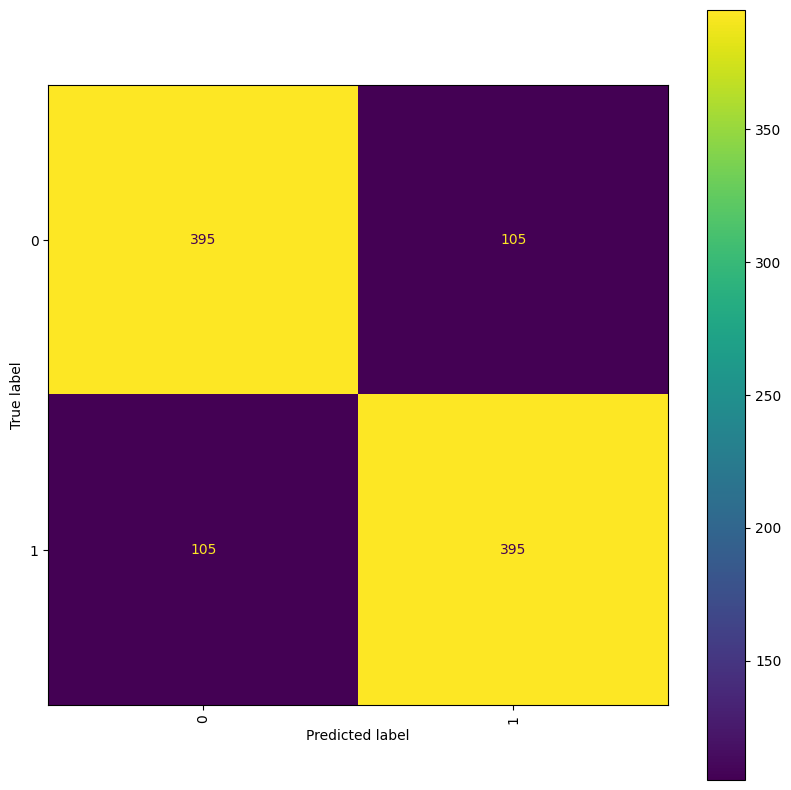

In [23]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))

    # Compute the confusion matrix
    y_pred = classifier.log_reg.predict(classifier.devX)
    cm = confusion_matrix(classifier.devY, y_pred)

    # Use ConfusionMatrixDisplay to plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, xticks_rotation="vertical", values_format="d")

    plt.show()

print_confusion(big_classifier)


### 2. Feature Weights

Next, let's look at the features that are most important for each of the classes (ranked by how strong their corresponding coefficient is). Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data? **No written response required.**

In [24]:
big_classifier.printWeights(n=25)

pos	0.783	pos_adj
pos	0.547	pos_score
pos	0.487	series
pos	0.485	amazing
pos	0.408	man
pos	0.381	perfect
pos	0.353	thought
pos	0.351	relationship
pos	0.350	new
pos	0.341	top
pos	0.341	simple
pos	0.331	you
pos	0.325	dead
pos	0.323	him
pos	0.323	fun
pos	0.322	performance
pos	0.316	saw
pos	0.314	violence
pos	0.314	probably
pos	0.311	two
pos	0.309	case
pos	0.305	seen
pos	0.298	story
pos	0.295	their
pos	0.294	singing

neg	-1.319	neg_adj
neg	-0.561	stupid
neg	-0.538	neg_score
neg	-0.528	acting
neg	-0.525	would
neg	-0.518	worst
neg	-0.517	idea
neg	-0.498	instead
neg	-0.494	bad
neg	-0.461	there
neg	-0.450	even
neg	-0.424	nothing
neg	-0.424	could
neg	-0.419	half
neg	-0.405	actors
neg	-0.400	watching
neg	-0.385	had
neg	-0.373	poor
neg	-0.365	no
neg	-0.361	waste
neg	-0.348	tv
neg	-0.342	vampire
neg	-0.338	're
neg	-0.329	look
neg	-0.324	killer



### 3. Misclassified Data Points

Next, let's look at the individual data points that are the hardest to classify correctly. Does it suggest any features you might create to disentangle them? **No written response required.**

In [25]:
def analyze(classifier):

    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))

analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1178,0.999999,pos,neg,"While I do not think this was a perfect 10, I do agree it was way above a 6 which is what it's rated here. No, Brokedown Palace was not perfect and yes it's plot has been done many times before. That doesn't mean it shouldn't be done again if it is done well and I think this movie had some strong moments. The acting of Claire Danes, as already mentioned many times, was flawless as was Kate Bec..."
1,1261,0.999965,neg,pos,"NATURAL BORN KILLERS (1994)Cinema Cut: R Director's Cut: NC-17It's an unusual Oliver Stone picture, but when I read he was on drugs during the filming, I needed no further explanation. 'Natural Born Killers' is a risky, mad, all out film-making that we do not get very often; strange, psychotic, artistic pictures.'Natural Born Killers' is basically the story of how two mass killers were popular..."
2,1551,0.999917,neg,pos,"I firmly believe that the best Oscar ceremony in recent years was in 2003 for two reasons: 1 ) Host Steve Martin was at his most wittiest: "" I saw the teamsters help Michael Moore into the trunk of his limo "" and "" I'll better not mention the gay mafia in case I wake up with a poodle's head in my bed "" 2 ) Surprise winners: No one had Adrien Brody down for best actor ( Genuine applause ) or Ro..."
3,1110,0.999788,neg,pos,"Before Stan Laurel became the smaller half of the all-time greatest comedy team, he laboured under contract to Broncho Billy Anderson in a series of cheapies, many of which were parodies of major Hollywood features. Following a dispute with Anderson, Laurel continued the informal series of parodies at Joe Rock's smaller (and more indigent) production company.Most of Laurel's parody films were ..."
4,1436,0.999771,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
5,1889,0.999695,pos,neg,"At times, this overtakes The Thing as my favourite horror film. While Carpenter's film is the more efficient and more entertaining flick, Kubrick's is more artistic, more thought-provoking, and probably scarier. It's one of the few films where I can look past its flaws and truly and wholly love it. I try not to compare it to the book  which I've only read once, a number of years ago, and whic..."
6,1456,0.999264,pos,neg,"Hardly a masterpiece. Not so well written. Beautiful cinematography i think not. This movie wasn't too terrible but it wasn't that much better than average. The main story dealing with highly immoral teens should have focused more on the forbidden romance and why this was... should have really gotten into it instead of scraping the surface with basically ""because mom says we can't."" Some parts..."
7,1787,0.999199,pos,neg,"My roommate had bought this documentary and invited me to watch it with her. She's from China and only heard so much about 9/11 and wanted to know the cold hard truth and she wanted me to tell her more after the documentary. I felt awful watching this documentary, it was like reliving the nightmare and it still brings tears to my eyes.But I'm extremely grateful that I watched this documentary,..."
8,1471,0.999163,pos,neg,"But the opposite, sorry bud, i completely understand how you can be dragged into a film because you relate to the subject ( and you have). This film is terrible, the main character would give any charlie brown subtitler a run for his money he just constantly mumbles which is always a laugh, most scenes just feel awkward with characters more often than not gazing across to another with a look o..."
9,1608,0.998810,neg,pos,"As good an advert for republicanism as you're ever likely to see,""Mayerlin

### 4. Hyperparameter Tuning

An important step in optimizing models is hyperparameter tuning. Hyperparameter tuning enables us to adjust the hyperparameters of our model, specifically those not learned from the data, to optimize its performance. Below, you will use K-fold cross-validation on the training data to get an estimate of your model's performance. For this deliverable, **replace `classifier` with the classifier you want to improve. Then, complete `param_grid` for `C` (values closer to 0 = stronger regularization)** to find which L2 regularization strength improves your model the most. For more information, please consult [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

*Note: we are unable to hyperparameter tune `min_feature_size` easily with the scikitlearn API (we hard coded `min_feature_size` in the `Classifier` class). Please try out different values manually.*

In [26]:
# import libraries
from sklearn.model_selection import KFold, GridSearchCV

# Parameter Grid for L2 regularization strength
# BEGIN SOLUTION
#param_grid = {'C': ...}
import numpy as np
param_grid = {'C': np.arange(0.1, 10, 0.5) }

# END SOLUTION

# initialize KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

classifier = big_classifier # TODO: Change to the classifier you want to hyperparameter tune

grid_search = GridSearchCV(estimator= classifier.log_reg, param_grid=param_grid, scoring='accuracy', cv=kf)
grid_search.fit(classifier.trainX, classifier.trainY)
best_params = grid_search.best_params_

# Which parameters performed best?
print(best_params)

{'C': 0.1}


## Deliverable 4: Short Answer (15 points)

Give a real-world example of where it is important to capture the percentage of false positives the model predicts and another example of a case where it is important to capture false negatives. Why might these measures be more valuable than finding the model's accuracy? (~50 words)

For banks, they need to consider about the credit card fraud detection. Capture false positives can help to avoid legitimate cardholders with unnecessary account freezes.
For people who use email, capture false negatives can help to prevent legitimate emails from being classified as spam, so people will not to overlook the important emails.